# Streamfunction

In [1]:
# filter some warning messages
import warnings
warnings.filterwarnings("ignore") 

# import os
# os.environ['NUMPY_EXPERIMENTAL_ARRAY_FUNCTION'] = '0'

In [ ]:
import numpy as np
import xesmf as xe
import xarray as xr

import copy

# from functions import func_conv_data

In [3]:
## File modified from https://pop-tools.readthedocs.io/en/latest/examples/region-mask.html
ocean_mask = xr.open_dataset("OceanMask.nc")
# ocean_mask['TLONG'] = ((ocean_mask.TLONG + 300) % 360) - 300

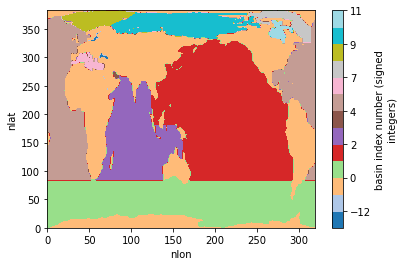

In [8]:
ocean_mask.REGION_MASK.plot.contourf(levels = np.array(np.unique(ocean_mask.REGION_MASK)), cmap = 'tab20')
###########################
## 1  Southern Ocean
## 2  Pacific Ocean
## 6  Atlantic Ocean + 8 + 11
## 10 Arctic Ocean

In [27]:
import intake
# from intake import open_catalog
# url = "https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/master.yaml"
# col = intake.open_catalog(url).climate.cmip6_gcs()

cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(cat_url)

In [28]:
def rename_coords(ds):
    ds = ds.copy()
    """Rename all depth dim to `lev`"""
    if "olevel" in ds.coords:
        ds = ds.rename({"olevel": "lev"})
    if "lev_partial" in ds.coords:
        ds = ds.rename({"lev_partial": "lev"})
    """Rename all latitude, longitude dim to `lat`,`lon`"""
    if 'latitude' in ds.coords:
        ds = ds.rename({'longitude': 'lon', 'latitude': 'lat'})
    if 'nav_lat' in ds.coords:
        ds = ds.rename({'nav_lon': 'lon', 'nav_lat': 'lat'})
    return ds

def get_dataset(col, var, freq, expe, model, grid):
    dataset = col.search(variable_id = var, table_id = freq, experiment_id = expe, 
                         source_id = model, grid_label = grid).to_dataset_dict(
        zarr_kwargs= {'consolidated': True, 'decode_times':True}, preprocess = rename_coords)
    dataset = dataset[list(dataset)[0]].squeeze('member_id').reset_coords('member_id', drop = True)
    return dataset

In [6]:
model_name = 'GFDL-CM4' 
experiment = 'piControl'
frequency = 'Omon'
variables = ['so', 'thetao', 'uo', 'vo']

In [29]:
list(col.search(variable_id = 'vo', source_id = 'GFDL-CM4'))

['CMIP.NOAA-GFDL.GFDL-CM4.1pctCO2.Omon.gn',
 'CMIP.NOAA-GFDL.GFDL-CM4.historical.Omon.gn',
 'CMIP.NOAA-GFDL.GFDL-CM4.abrupt-4xCO2.Omon.gn']

In [7]:
dataset_gn = get_dataset(col, variables, frequency, experiment, model_name, 'gn')
dataset_gr = get_dataset(col, variables, frequency, experiment, model_name, 'gr')


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [9]:
def func_regrid(ds, ds_out, gr_method = 'bilinear', reuse = False, clear = True):
    dsr = xe.Regridder(ds, ds_out, gr_method, periodic = True, reuse_weights = reuse, ignore_degenerate = True)
    dsr._grid_in = None
    dsr._grid_out = None
    dsr_out = dsr(ds)
    if clear:
        dsr.clean_weight_file()
    return dsr_out

## get convection index

In [10]:
# functions modified from Convection.ipynb

def sel_time(ds, start_year, end_year, month = None):
    ds = ds.isel(time = slice((start_year-1)*12, end_year*12))
    if month:
        ds = list(ds.groupby("time.month"))[month-1][-1]
    return ds

def smow(t):
    a = (999.842594, 6.793952e-2, -9.095290e-3, 1.001685e-4, -1.120083e-6,
         6.536332e-9)
    T68 = t * 1.00024
    return (a[0] + (a[1] + (a[2] + (a[3] + (a[4] + a[5] * T68) * T68) * T68) *
            T68) * T68)

def dens0(s, t):
    T68 = t * 1.00024
    b = (8.24493e-1, -4.0899e-3, 7.6438e-5, -8.2467e-7, 5.3875e-9)
    c = (-5.72466e-3, 1.0227e-4, -1.6546e-6)
    d = 4.8314e-4
    return (smow(t) + (b[0] + (b[1] + (b[2] + (b[3] + b[4] * T68) * T68) *
            T68) * T68) * s + (c[0] + (c[1] + c[2] * T68) * T68) * s *
            s ** 0.5 + d * s ** 2)

def func_mld(dens_diff, depths):
    if np.isnan(dens_diff[0]):
        mld = np.nan
    elif dens_diff[0] >= 0:
        mld = np.nan
    else:
        nthr_index = np.where(dens_diff > 0)[0]
        if len(nthr_index) == 0:
            naninds = np.where(np.isnan(dens_diff))[0]
            if len(naninds) > 0:
                nanindex = naninds[0]
            else:
                nanindex = len(depths)
            mld = depths[nanindex-1]
        else:
            nind = nthr_index[0] + 1
            mld = np.interp(0, dens_diff[:nind], depths[:nind])
    return mld

def xr_func_mld(dens):
    dens10 = dens.interp(lev = 10, method = 'linear')  # density at 10m
    dens_diff = dens - dens10 - 0.03               # density differences 
    mld = xr.apply_ufunc(
        func_mld, 
        dens_diff.chunk({"time":25, "lat":45, "lon":45}),  
        dens_diff.lev, 
        input_core_dims = [["lev"], ["lev"]], 
        vectorize = True,
        dask = "parallelized",
        output_dtypes = [dens_diff.lev.dtype])
    return mld

def select_conv_area_data(ds, conv_area):
    ds = ds.copy()
    ds = ds.where(conv_area > 0)
    ds = ds.groupby('time.year').mean(dim = 'time', skipna = True)
    ds = ds.mean(dim = 'lat', skipna = True).mean(dim = 'lon', skipna = True)
    return ds

def select_region(ds, region, reg_dict):
    return ds.sel(lon = reg_dict[region]['lon'], lat = reg_dict[region]['lat'], method="nearest")

def add_region_attrs(ds, region, reg_dict):
    ds.attrs['region_name'] = reg_dict[region]['name']
    ds.attrs['conv_index'] = reg_dict[region]['convind']
    ds.attrs['rep_lon'] = reg_dict[region]['rlon']
    ds.attrs['rep_lat'] = reg_dict[region]['rlat']
    return ds

def func_conv_data(dataset, region, start_year, end_year, reg_dict, month_no = 9, regrid = None):
    da_t = sel_time(dataset.thetao, start_year, end_year)
    da_s = sel_time(dataset.so, start_year, end_year)
    da_dens = sel_time(dens0(da_s, da_t), start_year, end_year, month = month_no)
    if not regrid == None:
        da_dens = func_regrid(da_dens, regrid)
        da_t = func_regrid(da_t, regrid)
        da_s = func_regrid(da_s, regrid)
    da_dens = select_region(da_dens, region, reg_dict = reg_dict)
    da_t = select_region(da_t, region, reg_dict = reg_dict)
    da_s = select_region(da_s, region, reg_dict = reg_dict)
    da_mld = xr_func_mld(da_dens)
    conv = xr.where(da_mld >= reg_dict[region]['convdepth'], da_mld, np.nan)
    conv_area = conv.mean(dim = 'time', skipna = True)
    da_t_conv = select_conv_area_data(da_t, conv_area)
    da_s_conv = select_conv_area_data(da_s, conv_area)
    conv_area = add_region_attrs(conv_area, region, reg_dict)
    da_t_conv = add_region_attrs(da_t_conv, region, reg_dict)
    da_s_conv = add_region_attrs(da_s_conv, region, reg_dict)
    ind_t = da_t_conv.interp(lev = da_t_conv.conv_index)
    conv_ind = -1 * (ind_t - ind_t.mean('year'))/ind_t.std('year')
    return conv_area, da_t_conv, da_s_conv, conv_ind

In [11]:
region_dict = {
    'ws':{'name':'Weddell Sea', # Weddell Sea [60W-30E, 90S-50S]
          'lon':np.concatenate((np.arange(300.1,360.1), np.arange(0.1,31.1))),
          'lat':np.arange(-90,-49),
          'rlon':345, # representative lon lat
          'rlat':-70,
          'convdepth':2000,  # mld >= 2000 as conv area
          'convind':2000},  # conv index -- temp at 1500m 
    'rs':{'name':'Ross Sea', # Ross Sea [160W-130E, 90S-50S]
          'lon':np.arange(160.1, 231.1),
          'lat':np.arange(-90,-49),
          'rlon':195,
          'rlat':-70,
          'convdepth':2000,
          'convind':500}, 
    'rs2':{'name':'Ross Sea', # Ross Sea with convindex = temp at 2000m
           'lon':np.arange(160.1, 231.1),
           'lat':np.arange(-90,-49),
           'rlon':195,
           'rlat':-70,
           'convdepth':2000,
           'convind':2000}, 
}  

In [12]:
start_year = 1
end_year = 500

In [13]:
__, __, __, conv_ind_ws = func_conv_data(dataset_gr, 'ws', start_year, end_year, region_dict)
__, __, __, conv_ind_rs = func_conv_data(dataset_gr, 'rs', start_year, end_year, region_dict)
__, __, __, conv_ind_rs2 = func_conv_data(dataset_gr, 'rs2', start_year, end_year, region_dict)

## Streamfunction

In [16]:
dataset_gr

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 180, lev: 35, lon: 360, time: 6000)
Coordinates:
  * lat        (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(180, 2), meta=np.ndarray>
  * lev        (lev) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03 6.5e+03
    lev_bnds   (lev, bnds) float64 dask.array<chunksize=(35, 2), meta=np.ndarray>
  * lon        (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(360, 2), meta=np.ndarray>
  * time       (time) object 0151-01-16 12:00:00 ... 0650-12-16 12:00:00
    time_bnds  (time, bnds) object dask.array<chunksize=(6000, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    so         (time, lev, lat, lon) float32 dask.array<chunksize=(25, 35, 180, 360), meta=np.ndarray>
    thetao     (time, lev, lat, lon) float32 dask.array<chunksize=(25, 35, 180, 360), meta=np.ndarray>
Attributes:
    physics_index:           1
    comment:                 <null ref>
    data_specs_version:      01.00.27
    references:              see further_info_url attribute
    activity_id:             CMIP
    parent_time_units:       days since 1700-1-1
    realization_index:       1
    further_info_url:        https://furtherinfo.es-doc.org/CMIP6.NOAA-GFDL.G...
    product:                 model-output
    variant_info:            N/A
    external_variables:      areacello volcello
    experiment_id:           piControl
    branch_time_in_parent:   54750.0
    table_id:                Omon
    tracking_id:             hdl:21.14100/d85abc4a-49a2-4d13-9ebd-63cf01c6fae...
    variant_label:           r1i1p1f1
    parent_mip_era:          CMIP6
    sub_experiment:          none
    frequency:               mon
    forcing_index:           1
    experiment:              pre-industrial control
    institution_id:          NOAA-GFDL
    Conventions:             CF-1.7 CMIP-6.0 UGRID-1.0
    nominal_resolution:      1x1 degree
    mip_era:                 CMIP6
    realm:                   ocean
    contact:                 gfdl.climate.model.info@noaa.gov
    parent_variant_label:    r1i1p1f1
    parent_source_id:        GFDL-CM4
    title:                   NOAA GFDL GFDL-CM4 model output prepared for CMI...
    institution:             National Oceanic and Atmospheric Administration,...
    parent_experiment_id:    piControl-spinup
    license:                 CMIP6 model data produced by NOAA-GFDL is licens...
    sub_experiment_id:       none
    source:                  GFDL-CM4 (2018): \naerosol: interactive\natmos: ...
    initialization_index:    1
    intake_esm_varname:      so\nthetao
    branch_time_in_child:    0.0
    source_type:             AOGCM
    version_id:              v20180701
    parent_activity_id:      CMIP
    history:                 File was processed by fremetar (GFDL analog of C...
    grid:                    ocean data regridded from tripolar - nominal 0.2...
    source_id:               GFDL-CM4
    branch_method:           standard
    grid_label:              gr
    intake_esm_dataset_key:  CMIP.NOAA-GFDL.GFDL-CM4.piControl.Omon.gr

In [14]:
data = dataset_gn.vo

AttributeError: 'Dataset' object has no attribute 'vo'

Reuse existing file: bilinear_384x320_1080x1440_peri.nc


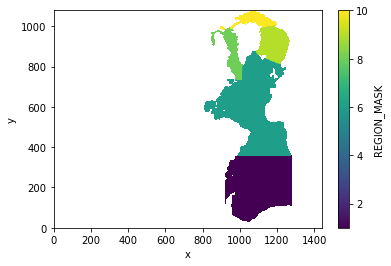

In [15]:
# Atlantic Ocean Mask
mask_a = ocean_mask.where(ocean_mask.REGION_MASK.isin([6, 8]))
mask_b = ocean_mask.where(ocean_mask.REGION_MASK.isin([1]))
mask_b = xr.merge([mask_b.REGION_MASK.where(mask_b.TLONG < 20), mask_b.REGION_MASK.where(mask_b.TLONG >= 290)], compat="no_conflicts")
mask_c = ocean_mask.where(ocean_mask.REGION_MASK.isin([9, 10]))
mask_c = xr.merge([mask_c.REGION_MASK.where(mask_c.TLONG < 20), mask_c.REGION_MASK.where(mask_c.TLONG >= 270)], compat="no_conflicts")
mask = xr.merge([mask_a, mask_b, mask_c], compat="no_conflicts")
mask = mask.rename({'TLONG': 'lon', 'TLAT': 'lat'})
ds_out = xr.Dataset({'lat': dataset_gn.lat, 'lon':dataset_gn.lon})
mask = func_regrid(mask.REGION_MASK, ds_out, reuse = True, clear = False)
mask.plot()

In [16]:
ds_v = data.where(~np.isnan(mask), drop = True)

In [17]:
ds_lat_bnds = dataset_gn.where(~np.isnan(mask), drop = True).lat_bnds
ds_lon_bnds = dataset_gn.where(~np.isnan(mask), drop = True).lon_bnds
####### vertices of the cells follow the order below
#(1)#########(2)
#           #
#           #
#           #
#           #
#(4)#########(3)

In [17]:
def calc_dx_dy_bnd(ds):
    from pyproj import Geod
    
    g = Geod(ellps='sphere')
    
    lonb = ds.lon_bnds.values
    latb = ds.lat_bnds.values
    
    dx = np.zeros((lonb.shape[0], lonb.shape[1]))
    dy = np.zeros((lonb.shape[0], lonb.shape[1]))
    
    for i in range(dx.shape[0]):
        for j in range(dx.shape[1]):
            _, _, dy[i,j] = g.inv(lonb[i,j,1], latb[i,j,1], lonb[i,j,2], latb[i,j,2])
            
    for i in range(dx.shape[0]):
        for j in range(dy.shape[1]):
            _, _, dx[i,j] = g.inv(lonb[i,j,0], latb[i,j,0], lonb[i,j,1], latb[i,j,1])
    
    return dx, dy

In [18]:
dep = np.squeeze(np.diff(dataset_gn.lev_bnds.values))

In [19]:
newdep = np.tile(dep[:, np.newaxis, np.newaxis], (1, ds_v.shape[2], ds_v.shape[3]))

In [20]:
vol_z = newdep * ds_v

In [36]:
z1 = vol_z.sel(lev = 1000, method = 'nearest').lev.values
z2 = vol_z.sel(lev = 2000, method = 'nearest').lev.values
z3 = vol_z.sel(lev = 3000, method = 'nearest').lev.values
z4 = vol_z.sel(lev = 4000, method = 'nearest').lev.values
z5 = vol_z.sel(lev = 5000, method = 'nearest').lev.values

vol_z_1 = vol_z.sel(lev = slice(None, z1)).sum(dim = 'lev', skipna = True).groupby('time.year').mean(dim = 'time', skipna = True)
vol_z_2 = vol_z.sel(lev = slice(z1+1, z2)).sum(dim = 'lev', skipna = True).groupby('time.year').mean(dim = 'time', skipna = True)
vol_z_3 = vol_z.sel(lev = slice(z2+1, z3)).sum(dim = 'lev', skipna = True).groupby('time.year').mean(dim = 'time', skipna = True)
vol_z_4 = vol_z.sel(lev = slice(z3+1, z4)).sum(dim = 'lev', skipna = True).groupby('time.year').mean(dim = 'time', skipna = True)
vol_z_5 = vol_z.sel(lev = slice(z4+1, z5)).sum(dim = 'lev', skipna = True).groupby('time.year').mean(dim = 'time', skipna = True)
vol_z_5p = vol_z.sel(lev = slice(z5+1, None)).mean(dim = 'lev', skipna = True).groupby('time.year').mean(dim = 'time', skipna = True)*2

In [21]:
newmask = mask.where(~np.isnan(mask), drop = True)

In [21]:
dx, dy = calc_dx_dy_bnd(dataset_gn.where(~np.isnan(mask), drop = True))

In [22]:
def func_integral_lon(ds, dx):
    vol_U = ds * dx / 1e6
    vol_U_Int = vol_U.sum(dim = 'x', skipna = True)
    return vol_U_Int

In [23]:
vol_lon = func_integral_lon(vol_z, dx)
vol_lon = vol_lon.groupby('time.year').mean(dim = 'time', skipna = True)

In [24]:
stfunc_sum = vol_lon.sum(dim = 'lev', skipna = True)
stfunc_cumsum = vol_lon.cumsum(dim = 'lev')
stream_function = stfunc_cumsum - stfunc_sum 

In [25]:
stream_function_mean = stream_function.mean(dim = 'year', skipna = True)

In [26]:
AMOC_max = stream_function.max(dim = 'lev')
SMOC_min = stream_function.min(dim = 'lev')

plot the steamfunciton profile
velocity profile at 30 S & 35 N

In [28]:
AMOC_max

<xarray.DataArray 'vo' (year: 500, y: 1048)>
dask.array<nanmax-aggregate, shape=(500, 1048), dtype=float64, chunksize=(1, 1048), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) float64 -78.04 -77.95 -77.85 -77.75 ... 89.3 89.41 89.51 89.62
  * year     (year) int64 151 152 153 154 155 156 ... 645 646 647 648 649 650

In [45]:
transport_0_1000_mean = vol_z_1.mean(dim = 'year', skipna = True)
transport_1000_2000_mean = vol_z_2.mean(dim = 'year', skipna = True)
transport_2000_3000_mean = vol_z_3.mean(dim = 'year', skipna = True)
transport_3000_4000_mean = vol_z_4.mean(dim = 'year', skipna = True)
transport_4000_5000_mean = vol_z_5.mean(dim = 'year', skipna = True)
transport_5000_below_mean = vol_z_5p.mean(dim = 'year', skipna = True)

In [42]:
maxvals = transport_0_1000_mean.max(dim = 'y')
minvals = transport_2000_3000_mean.min(dim = 'y')

In [ ]:
ind_max = np.argwhere(transport_0_1000_mean == [x]) for x in maxvals


# ind_max = np.array([np.argwhere(transport_0_1000_mean == [x]) for x in maxvals])
#     ind_max=np.concatenate(ind_max).astype(None)
#     ind_max=np.concatenate(ind_max).astype(None)
#     ii_max=ind_max[0::2].astype(int)
#     jj_max=ind_max[1::2].astype(int)
#     ind_min = np.array([np.argwhere(transport_2000_3000_mean == [x]) for x in minvals])
#     ind_min=np.concatenate(ind_min).astype(None)
#     ind_min=np.concatenate(ind_min).astype(None)
#     ii_min=ind_min[0::2].astype(int)
#     jj_min=ind_min[1::2].astype(int)

In [22]:
def calc_dx_dy(ds, bnd = False):
    ''' This definition calculates the distance 
        between grid points that are in
        a latitude/longitude format.
        
        Using pyproj GEOD; different Earth Shapes 
        https://jswhit.github.io/pyproj/pyproj.Geod-class.html
        Common shapes: 'sphere', 'WGS84', 'GRS80'
        
        Accepts, 1D arrays for latitude and longitude
        
        Returns: dx, dy; 2D arrays of distances 
                       between grid points in the x and y direction in meters
        ------------
        modified from:
        https://github.com/Unidata/MetPy/issues/288#issuecomment-279481555
    '''
    from pyproj import Geod
    
    g = Geod(ellps='sphere')
    
    lon = ds.lon.values
    lat = ds.lat.values
    
    dx = np.empty(ds.lon.shape)
    dy = np.zeros(ds.lat.shape)
    
    for i in range(dx.shape[0]-1):
        for j in range(dx.shape[1]):
            _, _, dy[i,j] = g.inv(lon[i,j], lat[i,j], lon[i+1,j], lat[i+1,j])
    dy[i+1,:] = dy[i,:]
            
    for i in range(dx.shape[0]):
        for j in range(dy.shape[1]-1):
            _, _, dx[i,j] = g.inv(lon[i,j], lat[i,j], lon[i,j+1], lat[i,j+1])
    dx[:,j+1] = dx[:,j]
    
    return dx, dy

In [23]:
dx, dy = calc_dx_dy(ds_v)

In [17]:
ds_out = xe.util.grid_global(1, 1)
ds_out  # contains lat/lon values of cell centers and boundaries.

<xarray.Dataset>
Dimensions:  (x: 360, x_b: 361, y: 180, y_b: 181)
Coordinates:
    lon      (y, x) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
    lat      (y, x) float64 -89.5 -89.5 -89.5 -89.5 ... 89.5 89.5 89.5 89.5
    lon_b    (y_b, x_b) int64 -180 -179 -178 -177 -176 ... 176 177 178 179 180
    lat_b    (y_b, x_b) int64 -90 -90 -90 -90 -90 -90 -90 ... 90 90 90 90 90 90
Dimensions without coordinates: x, x_b, y, y_b
Data variables:
    *empty*

In [15]:
def func_barotropicstream(ds, v, ds_ocean, ocean_no):    
    dep = np.squeeze(np.diff(ds.lev_bnds.values))
    mask = ds_ocean.where(ds_ocean.REGION_MASK.isin(ocean_no))
    mask = mask.rename({'TLONG': 'lon', 'TLAT': 'lat'})
    ds_out = xr.Dataset({'lat': ds.lat, 'lon':ds.lon})
    mask = func_regrid(mask.REGION_MASK, ds_out, reuse = True, clear = False)
    ds_v = ds[v].where(~np.isnan(mask), drop = True)
    newmask = mask.where(~np.isnan(mask), drop = True)
    newdep = np.tile(dep[:, np.newaxis, np.newaxis], (1, ds_v.shape[2], ds_v.shape[3]))
    vol_z = newdep * ds_v
    vol_depth = vol_z.sum(dim = 'lev', skipna = True)
    vol_depth_ann = vol_depth.groupby('time.year').mean(dim = 'time', skipna = True)
    
    dx, dy = calc_dx_dy(ds_v)
    
    if v == 'uo':
        vol_U = vol_depth_ann * dy / 1e6
        vol_U_Int = vol_U.cumsum(dim = 'y', skipna = True).where(~np.isnan(newmask))
    elif v == 'vo':
        vol_U = vol_depth_ann * dx / 1e6
        vol_U_Int = vol_U.reindex(x=vol_U.x[::-1]).cumsum(dim = 'x', skipna = True)
        vol_U_Int = vol_U_Int.reindex(x=vol_U_Int.x[::-1]).where(~np.isnan(newmask))
        vol_U_Int['lon'] = vol_U['lon']
        vol_U_Int['lat'] = vol_U['lat']
    return vol_U_Int

In [16]:
Sv_U_SO = func_barotropicstream(ds_vu, 'uo', ocean_mask, [1])
Sv_V_Atl = func_barotropicstream(ds_vu, 'vo', ocean_mask, [6, 8, 11])
Sv_V_Pac = func_barotropicstream(ds_vu, 'vo', ocean_mask, [2])

Reuse existing file: bilinear_384x320_1080x1440_peri.nc
Reuse existing file: bilinear_384x320_1080x1440_peri.nc
Reuse existing file: bilinear_384x320_1080x1440_peri.nc


In [17]:
Sv_U_SO_ave = Sv_U_SO.mean(dim = 'year', skipna = True)
Sv_V_Atl_ave = Sv_V_Atl.mean(dim = 'year', skipna = True)
Sv_V_Pac_ave = Sv_V_Pac.mean(dim = 'year', skipna = True)

In [27]:
from dask_gateway import Gateway
gateway = Gateway()
options = gateway.cluster_options()

options.worker_cores = 16 #16 / 4
options.worker_memory = 32 #32 / 8  

cluster = gateway.new_cluster(options)
cluster.adapt(minimum = 0, maximum = 120)

client = cluster.get_client() 
cluster

In [38]:
options

In [20]:
Sv_U_SO_ave = Sv_U_SO_ave.load()

In [21]:
Sv_V_Atl_ave = Sv_V_Atl_ave.load()

In [22]:
Sv_V_Pac_ave = Sv_V_Pac_ave.load()

In [28]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as colors

Text(0.5, 1.0, 'Barotropic Streamfunction [Integral of V East to West]\n North Atlantic, year 1-500, GFDL-CM4')

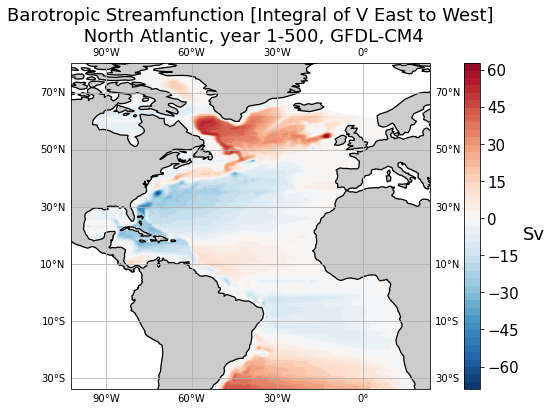

In [39]:
plt_da = Sv_V_Atl_ave

fig = plt.figure(figsize=(12,6))
ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

ax.add_feature(cfeature.LAND, zorder=1, color='0.8')
ax.add_feature(cfeature.COASTLINE, linewidth=1.25)

gl = ax.gridlines(
    xlocs = np.arange(-180,180,30), 
    ylocs = np.arange(-90,90,20),
    draw_labels=True)#, y_inline=True)

divnorm = colors.TwoSlopeNorm(vmin=-70., vcenter=0, vmax=70)
im = ax.contourf(plt_da.lon, plt_da.lat, plt_da, transform=ccrs.PlateCarree(), levels = 50, norm=divnorm, cmap=plt.cm.RdBu_r)
cbar = plt.colorbar(im)
cbar.set_label('Sv', fontsize=18, rotation=0, horizontalalignment = 'left')
cbar.ax.tick_params(labelsize=15) 
plt.title('Barotropic Streamfunction [Integral of V East to West]\n North Atlantic, year {}-{}, GFDL-CM4'.format(start_year, end_year), fontsize=18)

Text(0.5, 1.0, 'Barotropic Streamfunction [Integral of V East to West]\n North Pacific, year 1-500, GFDL-CM4')

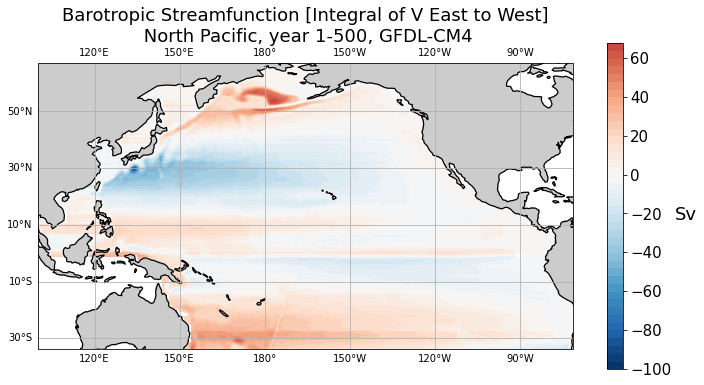

In [41]:
plt_da = Sv_V_Pac_ave

fig = plt.figure(figsize=(12,6))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
# ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

ax.add_feature(cfeature.LAND, zorder=1, color='0.8')
ax.add_feature(cfeature.COASTLINE, linewidth=1.25)

gl = ax.gridlines(
    xlocs = np.arange(-180,180,30), 
    ylocs = np.arange(-90,90,20),
    draw_labels=True)#, y_inline=True)

divnorm = colors.TwoSlopeNorm(vmin=-100., vcenter=0, vmax=100)
im = ax.contourf(plt_da.lon, plt_da.lat, plt_da, transform=ccrs.PlateCarree(), levels = 50, norm=divnorm, cmap=plt.cm.RdBu_r)
cbar = plt.colorbar(im)
cbar.set_label('Sv', fontsize=18, rotation=0, horizontalalignment = 'left')
cbar.ax.tick_params(labelsize=15) 
plt.title('Barotropic Streamfunction [Integral of V East to West]\n North Pacific, year {}-{}, GFDL-CM4'.format(start_year, end_year), fontsize=18)

Text(0.5, 1.0, 'Barotropic Streamfunction [Integral of U South to North]\n Southern Ocean, year 1-500, GFDL-CM4')

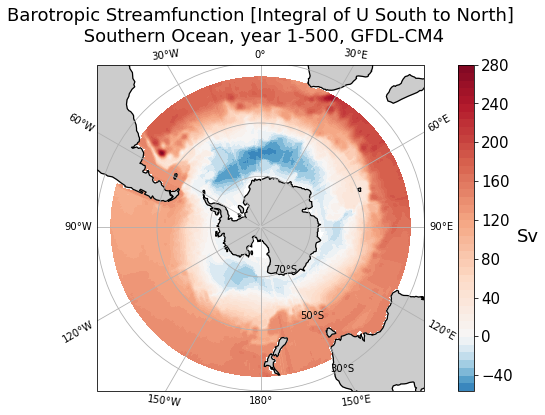

In [43]:
plt_da = Sv_U_SO_ave 

fig = plt.figure(figsize=(12,6))
ax = plt.axes(projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

ax.add_feature(cfeature.LAND, zorder=1, color='0.8')
ax.add_feature(cfeature.COASTLINE, linewidth=1.25)

gl = ax.gridlines(
    xlocs = np.arange(-180,180,30), 
    ylocs = np.arange(-90,90,20),
    draw_labels=True, y_inline=True)

divnorm = colors.TwoSlopeNorm(vmin=-80., vcenter=0, vmax=300)
im = ax.contourf(plt_da.lon, plt_da.lat, plt_da, transform=ccrs.PlateCarree(), levels = 50, norm=divnorm, cmap=plt.cm.RdBu_r)
cbar = plt.colorbar(im)
cbar.set_label('Sv', fontsize=18, rotation=0, horizontalalignment = 'left')
cbar.ax.tick_params(labelsize=15) 
plt.title('Barotropic Streamfunction [Integral of U South to North]\n Southern Ocean, year {}-{}, GFDL-CM4'.format(start_year, end_year), fontsize=18)

In [30]:
def func_boundary(ds, latlon, boundary):
    ds = ds.where((ds[latlon] <= boundary[1]) & (ds[latlon] >= boundary[0]), drop = True)
    return ds

In [31]:
Sv_U_SO_WS = func_boundary(func_boundary(Sv_U_SO, 'lon', [-60, 20]), 'lat', [-90, -55])
Sv_U_SO_WS_min = Sv_U_SO_WS.min(dim=['x','y'], skipna = True)

In [32]:
Sv_U_SO_RS = func_boundary(func_boundary(Sv_U_SO, 'lon', [-190, -130]), 'lat', [-90, -60])
Sv_U_SO_RS_min = Sv_U_SO_RS.min(dim=['x','y'], skipna = True)

In [33]:
Sv_U_SO_WS_min = Sv_U_SO_WS_min.load()

Text(0.5, 1.0, 'Barotropic Streamfunction (Normalized), Weddell Sea, year 1-500, GFDL-CM4')

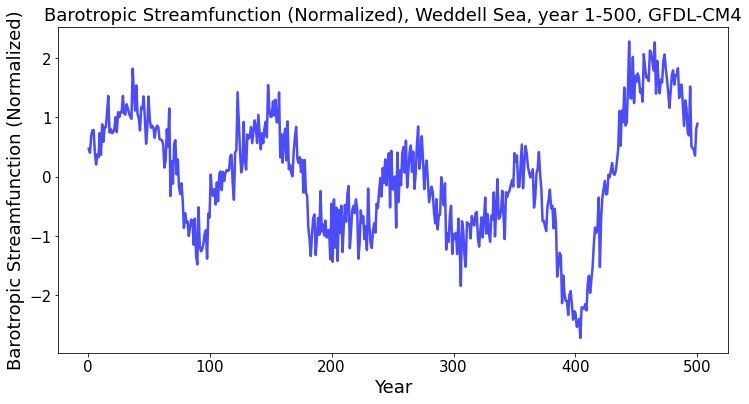

In [44]:
pltind = -1*(Sv_U_SO_WS_min - Sv_U_SO_WS_min.mean('year'))/Sv_U_SO_WS_min.std('year')

fig = plt.figure(figsize=(12,6))

plt.plot(pltind.year-150, pltind, 'b', linewidth = 2.5, alpha=0.7)

plt.ylabel('Barotropic Streamfunction (Normalized)', fontsize=18)
plt.xlabel('Year', fontsize=18)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('Barotropic Streamfunction (Normalized), Weddell Sea, year {}-{}, GFDL-CM4'.format(start_year, end_year), fontsize=18)

In [38]:
Sv_U_SO_RS_min = Sv_U_SO_RS_min.load()

Text(0.5, 1.0, 'Barotropic Streamfunction (Normalized), Ross Sea, year 1-500, GFDL-CM4')

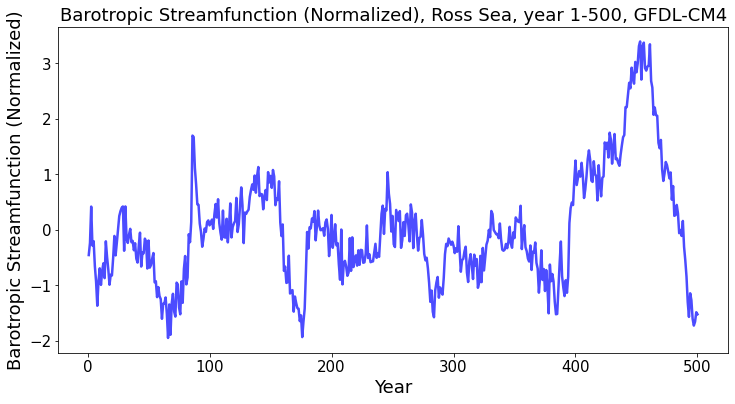

In [45]:
pltind = -1*(Sv_U_SO_RS_min - Sv_U_SO_RS_min.mean('year'))/Sv_U_SO_RS_min.std('year')

fig = plt.figure(figsize=(12,6))

plt.plot(pltind.year-150, pltind, 'b', linewidth = 2.5, alpha=0.7)
# l = plt.axhline(y=-0.5, color='k', linestyle ='--')
# l = plt.axhline(y=0, color='k')
# l = plt.axhline(y=0.5, color='k', linestyle ='--')

# plt.text(4, 1.2, 'Conv.', horizontalalignment='left', verticalalignment='center', fontsize=20, color='b')
# plt.text(4, -1.2, 'Non-Conv.', horizontalalignment='left', verticalalignment='center', fontsize=20, color='b')

plt.ylabel('Barotropic Streamfunction (Normalized)', fontsize=18)
plt.xlabel('Year', fontsize=18)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('Barotropic Streamfunction (Normalized), Ross Sea, year {}-{}, GFDL-CM4'.format(start_year, end_year), fontsize=18)

In [46]:
Sv_U_SO_RS_min_norm = (Sv_U_SO_RS_min - Sv_U_SO_RS_min.mean('year'))/Sv_U_SO_RS_min.std('year')*(-1)
Sv_U_SO_WS_min_norm = (Sv_U_SO_WS_min - Sv_U_SO_WS_min.mean('year'))/Sv_U_SO_WS_min.std('year')*(-1)

In [29]:
conv_ind_ws = conv_ind_ws.load()

In [30]:
conv_ind_rs = conv_ind_rs.load()

In [31]:
conv_ind_rs2 = conv_ind_rs2.load()

In [32]:
AMOC_max = AMOC_max.load()

In [33]:
SMOC_min = SMOC_min.load()

In [72]:
dataset_gn.lon.values[:,1115]

array([-20.356283, -20.414085, -20.4691  , ...,  52.530033,  55.501423,
        58.49768 ], dtype=float32)

In [73]:
dataset_gn.sel(y = AMOC_max.y).lat.values[:,1115]

array([-78.04986 , -77.94936 , -77.84808 , ...,  87.86748 ,  87.895035,
        87.91734 ], dtype=float32)

Text(0.5, 1.0, 'Weddell Sea peak convection vs. AMOC (max streamfunction)\n year 1 - 500, GFDL-CM4')

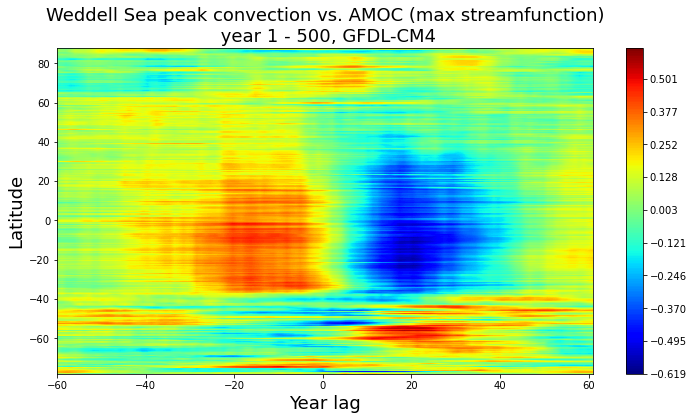

In [79]:
lag_time = 60

fig = plt.figure(figsize=(12,6))

pltdata = []
for i in range(len(AMOC_max.y)):
    r = lag_cor_data(conv_ind_ws,AMOC_max.isel(y=i).values, lag_time)
    pltdata.append(r)
pltdata = np.asarray(pltdata)
x = np.linspace(-lag_time, lag_time+1, 2*lag_time)
y = dataset_gn.sel(y = AMOC_max.y).lat.values[:,1115] # AMOC_max.y.values

x,y = np.meshgrid(x,y)
cmap_limit = np.nanmax(np.abs(pltdata))
levels = np.linspace(-cmap_limit,cmap_limit,200)
im = plt.contourf(x, y, pltdata, levels, latlon = True, cmap = plt.cm.jet)
cb = plt.colorbar(im)
plt.xlabel('Year lag', fontsize = 18)
plt.ylabel('Latitude', fontsize = 18)
# plt.xlim([-35, 35])
# plt.xticks(fontsize = 20); plt.yticks(fontsize = 20)
plt.title('Weddell Sea peak convection vs. AMOC (max streamfunction)\n year {} - {}, {}'.format(start_year, end_year, model_name), 
          fontsize = 18)

Text(0.5, 1.0, 'Ross Sea peak convection (2000m) vs. AMOC (max streamfunction)\n year 1 - 500, GFDL-CM4')

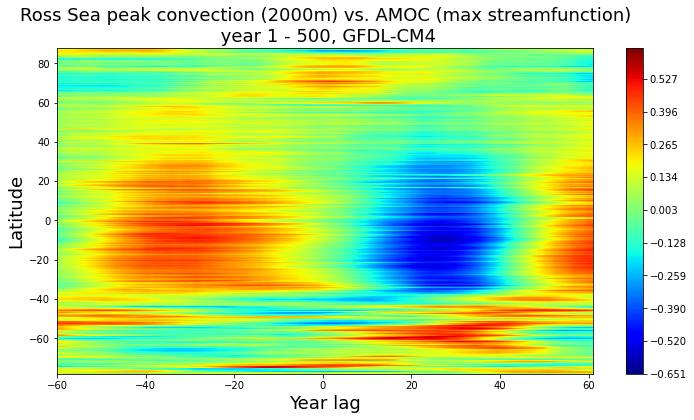

In [75]:
lag_time = 60

fig = plt.figure(figsize=(12,6))

pltdata = []
for i in range(len(AMOC_max.y)):
    r = lag_cor_data(conv_ind_rs2, AMOC_max.isel(y=i).values, lag_time)
    pltdata.append(r)
pltdata = np.asarray(pltdata)
x = np.linspace(-lag_time, lag_time+1, 2*lag_time)
y = dataset_gn.sel(y = AMOC_max.y).lat.values[:,1115] # AMOC_max.y.values

x,y = np.meshgrid(x,y)
cmap_limit = np.nanmax(np.abs(pltdata))
levels = np.linspace(-cmap_limit,cmap_limit,200)
im = plt.contourf(x, y, pltdata, levels, latlon = True, cmap = plt.cm.jet)
cb = plt.colorbar(im)
plt.xlabel('Year lag', fontsize = 18)
plt.ylabel('Latitude', fontsize = 18)
# plt.xticks(fontsize = 20); plt.yticks(fontsize = 20)
plt.title('Ross Sea peak convection (2000m) vs. AMOC (max streamfunction)\n year {} - {}, {}'.format(start_year, end_year, model_name), 
          fontsize = 18)

Text(0.5, 1.0, 'Ross Sea peak convection (500m) vs. AMOC (max streamfunction)\n year 1 - 500, GFDL-CM4')

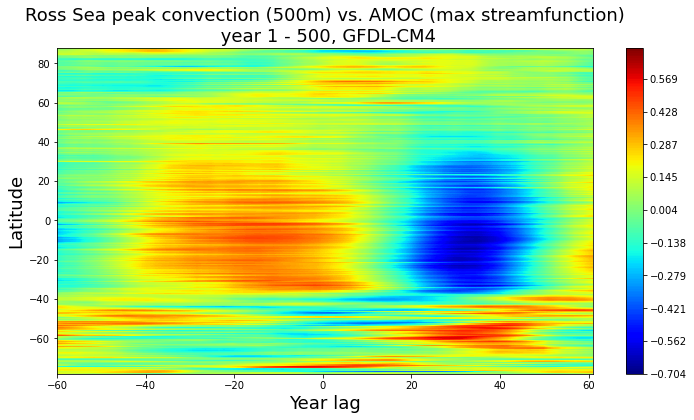

In [78]:
lag_time = 60

fig = plt.figure(figsize=(12,6))

pltdata = []
for i in range(len(AMOC_max.y)):
    r = lag_cor_data(conv_ind_rs, AMOC_max.isel(y=i).values, lag_time)
    pltdata.append(r)
pltdata = np.asarray(pltdata)
x = np.linspace(-lag_time, lag_time+1, 2*lag_time)
y = dataset_gn.sel(y = AMOC_max.y).lat.values[:,1115] # AMOC_max.y.values

x,y = np.meshgrid(x,y)
cmap_limit = np.nanmax(np.abs(pltdata))
levels = np.linspace(-cmap_limit,cmap_limit,200)
im = plt.contourf(x, y, pltdata, levels, latlon = True, cmap = plt.cm.jet)
cb = plt.colorbar(im)
plt.xlabel('Year lag', fontsize = 18)
plt.ylabel('Latitude', fontsize = 18)
# plt.xticks(fontsize = 20); plt.yticks(fontsize = 20)
plt.title('Ross Sea peak convection (500m) vs. AMOC (max streamfunction)\n year {} - {}, {}'.format(start_year, end_year, model_name), 
          fontsize = 18)

In [41]:
from scipy import stats, signal

In [91]:
AMOC_max_BWfilt = copy.deepcopy(AMOC_max)

In [100]:
AMOC_max_BWfilt.isel(y = 0)

In [42]:
# Butterworth filter (?)
CutOff_T = 35 # Cut-off period 
n_order = 4 # Order of filtering

fs = 1  # Sampling frequency, equal to 1 year in our case
fc = 1/CutOff_T  # Cut-off frequency of the filter
ww = fc / (fs / 2) # Normalize the frequency
bb, aa = signal.butter(n_order, ww, 'low')

conv_ind_ws_BWfilt = signal.filtfilt(bb, aa, conv_ind_ws)
# conv_ind_rs_BWfilt = signal.filtfilt(bb, aa, conv_ind_rs)
conv_ind_rs2_BWfilt = signal.filtfilt(bb, aa, conv_ind_rs2)

In [43]:
AMOC_max_BWfilt = []
for yi in AMOC_max.y:
    AMOC_max_BWfilt.append(signal.filtfilt(bb, aa, AMOC_max.sel(y = yi).values))

Text(0.5, 1.0, 'Ross Sea peak convection (500m) vs. AMOC (max streamfunction) \n Butterworth filtered (35yr cur-off, 4th order), year 1 - 500, GFDL-CM4')

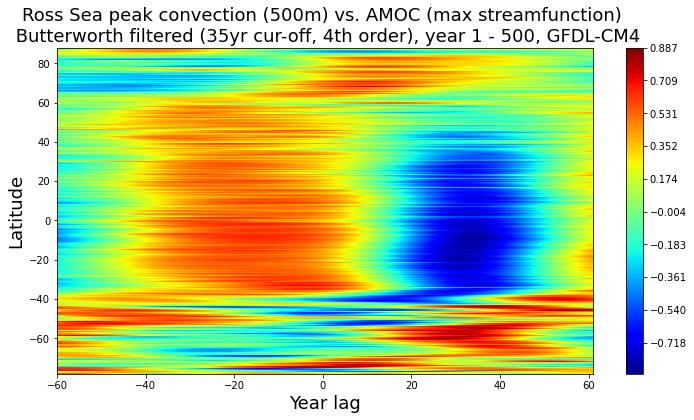

In [126]:
lag_time = 60

fig = plt.figure(figsize=(12,6))

pltdata = []
for i in range(len(AMOC_max.y)):
    r = lag_cor_data(conv_ind_rs_BWfilt, AMOC_max_BWfilt[i], lag_time)
    pltdata.append(r)
pltdata = np.asarray(pltdata)
x = np.linspace(-lag_time, lag_time+1, 2*lag_time)
y = dataset_gn.sel(y = AMOC_max.y).lat.values[:,1115] # AMOC_max.y.values

x,y = np.meshgrid(x,y)
cmap_limit = np.nanmax(np.abs(pltdata))
levels = np.linspace(-cmap_limit,cmap_limit,200)
im = plt.contourf(x, y, pltdata, levels, latlon = True, cmap = plt.cm.jet)
cb = plt.colorbar(im)
plt.xlabel('Year lag', fontsize = 18)
plt.ylabel('Latitude', fontsize = 18)
# plt.xticks(fontsize = 20); plt.yticks(fontsize = 20)
plt.title('Ross Sea peak convection (500m) vs. AMOC (max streamfunction) \n Butterworth filtered ({}yr cur-off, {}th order), year {} - {}, {}'.format(
    CutOff_T, n_order, start_year, end_year, model_name), fontsize = 18)

Text(0.5, 1.0, 'Ross Sea peak convection (2000m) vs. AMOC (max streamfunction) \n Butterworth filtered (35yr cur-off, 4th order), year 1 - 500, GFDL-CM4')

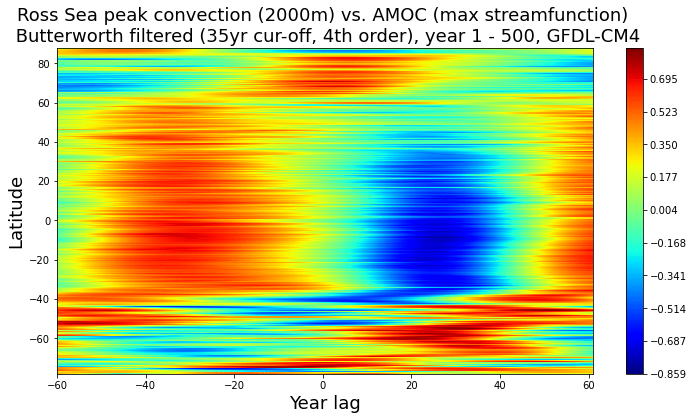

In [127]:
lag_time = 60

fig = plt.figure(figsize=(12,6))

pltdata = []
for i in range(len(AMOC_max.y)):
    r = lag_cor_data(conv_ind_rs2_BWfilt, AMOC_max_BWfilt[i], lag_time)
    pltdata.append(r)
pltdata = np.asarray(pltdata)
x = np.linspace(-lag_time, lag_time+1, 2*lag_time)
y = dataset_gn.sel(y = AMOC_max.y).lat.values[:,1115] # AMOC_max.y.values

x,y = np.meshgrid(x,y)
cmap_limit = np.nanmax(np.abs(pltdata))
levels = np.linspace(-cmap_limit,cmap_limit,200)
im = plt.contourf(x, y, pltdata, levels, latlon = True, cmap = plt.cm.jet)
cb = plt.colorbar(im)
plt.xlabel('Year lag', fontsize = 18)
plt.ylabel('Latitude', fontsize = 18)
# plt.xticks(fontsize = 20); plt.yticks(fontsize = 20)
plt.title('Ross Sea peak convection (2000m) vs. AMOC (max streamfunction) \n Butterworth filtered ({}yr cur-off, {}th order), year {} - {}, {}'.format(
    CutOff_T, n_order, start_year, end_year, model_name), fontsize = 18)

In [55]:
AMOC_max_BWfilt_cut = np.array(AMOC_max_BWfilt)[(AMOC_max.y > -70) & (AMOC_max.y < 70)]

In [57]:
AMOC_new_y = AMOC_max.y[(AMOC_max.y > -70) & (AMOC_max.y < 70)]

Text(0.5, 1.0, 'Weddell Sea peak convection vs. AMOC (max streamfunction) \n Butterworth filtered (35yr cur-off, 4th order), year 1 - 500, GFDL-CM4')

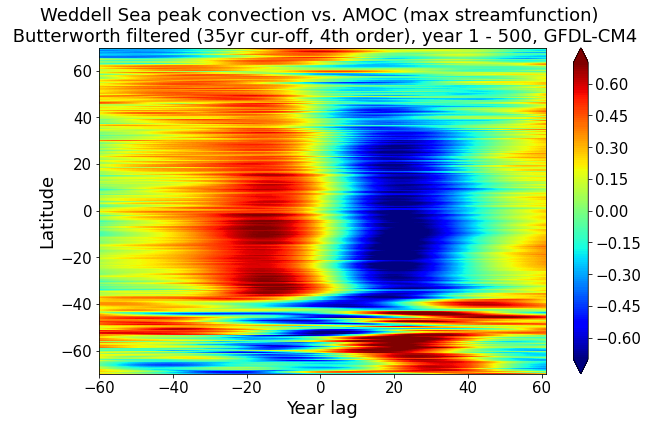

In [66]:
lag_time = 60

fig = plt.figure(figsize=(10,6))

# pltdata = []
# for i in range(len(AMOC_new_y)):
#     r = lag_cor_data(conv_ind_ws_BWfilt, AMOC_max_BWfilt_cut[i], lag_time)
#     pltdata.append(r)
# pltdata = np.asarray(pltdata)
x = np.linspace(-lag_time, lag_time+1, 2*lag_time)
y = AMOC_new_y.values

x,y = np.meshgrid(x,y)
cmap_limit = np.nanmax(np.abs(pltdata))
levels = np.arange(-0.7,0.71,0.01)
im = plt.contourf(x, y, pltdata, levels, extend = 'both', cmap = plt.cm.jet)
cb = plt.colorbar(im)
cb.ax.tick_params(labelsize=15)
plt.xlabel('Year lag', fontsize = 18)
plt.ylabel('Latitude', fontsize = 18)
plt.xticks(fontsize = 15)    
plt.yticks(fontsize = 15)
plt.title('Weddell Sea peak convection vs. AMOC (max streamfunction) \n Butterworth filtered ({}yr cur-off, {}th order), year {} - {}, {}'.format(
    CutOff_T, n_order, start_year, end_year, model_name), fontsize = 18)

In [45]:
def lag_cor_data(x,y,lag):
    stat=[]
    from scipy import stats
    for i in range(2*lag):
        slope, intercept, r_value, p_value, std_err = stats.linregress(x[lag:len(x)-lag], y[i:len(y)-2*lag+i])
        stat.append(r_value)
    return stat

Text(0.5, 1.0, 'Convection index, Ross Sea, year 1-500, GFDL-CM4')

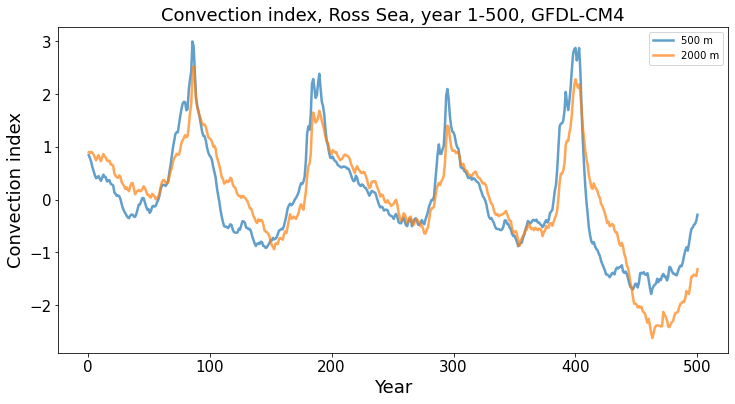

In [85]:
fig = plt.figure(figsize=(12,6))

# plt.plot(conv_ind_ws.year-150, conv_ind_ws, linewidth = 2.5, alpha=0.7)
plt.plot(conv_ind_rs.year-150, conv_ind_rs, linewidth = 2.5, alpha=0.7, label = '500 m')
plt.plot(conv_ind_rs2.year-150, conv_ind_rs2, linewidth = 2.5, alpha=0.7, label = '2000 m')

plt.ylabel('Convection index', fontsize=18)
plt.xlabel('Year', fontsize=18)
plt.legend()
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('Convection index, Ross Sea, year {}-{}, {}'.format(start_year, end_year, model_name), fontsize=18)

In [36]:
def lag_cor(x,y,lag, c, l):
    stat=[]
    from scipy import stats
    for i in range(2*lag):
        slope, intercept, r_value, p_value, std_err = stats.linregress(x[lag:len(x)-lag], y[i:len(y)-2*lag+i])
        stat.append(r_value)
    x=np.linspace(-lag, lag+1, 2*lag)
    plt.grid(True, which="both", ls="-", color='0.65')
    plt.plot(x, stat, c, label=l, linewidth=3.0)

In [141]:
def runningMeanFast(x, N):
    return np.convolve(x, np.ones((N,))/N)[(N-1):]

In [147]:
AMOC_dict = {}
for yi in [-50, -30, 30, 50]:
    AMOC_dict[str(yi)] = runningMeanFast(AMOC_max.sel(y = yi, method = 'nearest'), 10)

Text(0.5, 1.0, 'Peak Ross Sea Convection (2000m) lagged correlation , year 1-500, GFDL-CM4')

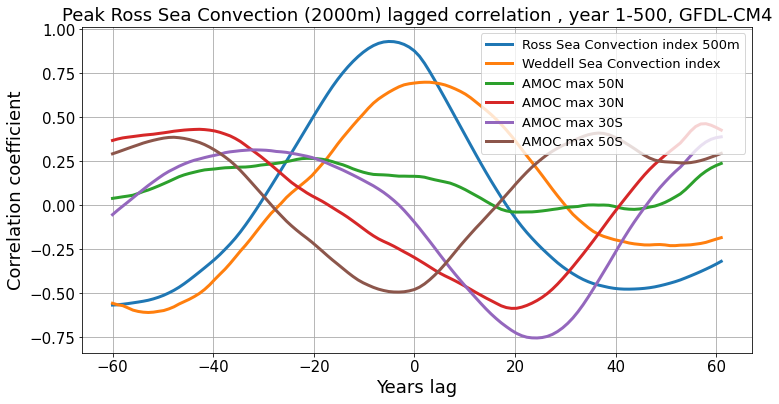

In [148]:
lag_time = 60

fig = plt.figure(figsize = (12,6))
lag_cor(conv_ind_rs2, conv_ind_rs, lag_time, 'C0', 'Ross Sea Convection index 500m')
lag_cor(conv_ind_rs2, conv_ind_ws, lag_time, 'C1', 'Weddell Sea Convection index')
lag_cor(conv_ind_rs2, AMOC_dict['50'], lag_time, 'C2', 'AMOC max 50N')
lag_cor(conv_ind_rs2, AMOC_dict['30'], lag_time, 'C3', 'AMOC max 30N')
lag_cor(conv_ind_rs2, AMOC_dict['-30'], lag_time, 'C4','AMOC max 30S')
lag_cor(conv_ind_rs2, AMOC_dict['-50'], lag_time, 'C5','AMOC max 50S')


# lag_cor(conv_ind_rs2, Sv_U_SO_WS_min_norm[:-9],lag_time,'c','Weddell Sea Barotrophic Streamfunction min')


''' !!!Problem need to be solved here !!!!'''
##### Q: Why -9 here? ######

plt.xlabel('Years lag', fontsize=18)
plt.ylabel('Correlation coefficient', fontsize=18)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(fontsize = 13)
plt.title('Peak Ross Sea Convection (2000m) lagged correlation , year {}-{}, {}'.format(
    start_year, end_year, model_name), fontsize=18)

Text(0.5, 1.0, 'Peak Ross Sea Convection (2000m) lagged correlation , year 1-500, GFDL-CM4')

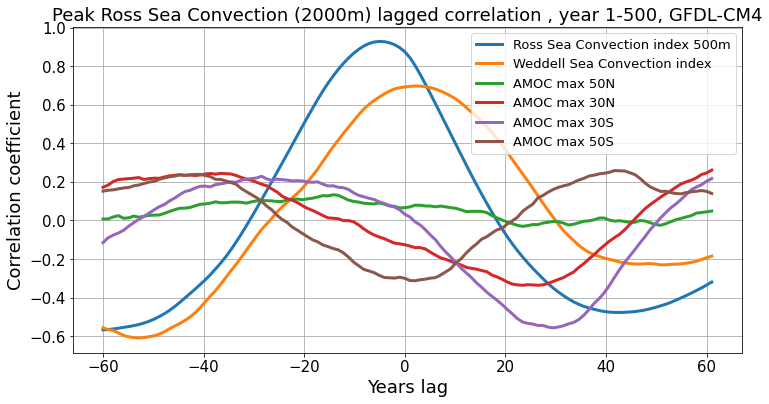

In [149]:
lag_time = 60

fig = plt.figure(figsize = (12,6))
lag_cor(conv_ind_rs2, conv_ind_rs, lag_time, 'C0', 'Ross Sea Convection index 500m')
lag_cor(conv_ind_rs2, conv_ind_ws, lag_time, 'C1', 'Weddell Sea Convection index')
lag_cor(conv_ind_rs2, AMOC_max.sel(y=50, method = 'nearest'), lag_time, 'C2', 'AMOC max 50N')
lag_cor(conv_ind_rs2, AMOC_max.sel(y=30, method = 'nearest'), lag_time, 'C3', 'AMOC max 30N')
lag_cor(conv_ind_rs2, AMOC_max.sel(y=-30, method = 'nearest'), lag_time, 'C4','AMOC max 30S')
lag_cor(conv_ind_rs2, AMOC_max.sel(y=-50, method = 'nearest'), lag_time, 'C5','AMOC max 50S')


# lag_cor(conv_ind_rs2, Sv_U_SO_WS_min_norm[:-9],lag_time,'c','Weddell Sea Barotrophic Streamfunction min')


''' !!!Problem need to be solved here !!!!'''
##### Q: Why -9 here? ######

plt.xlabel('Years lag', fontsize=18)
plt.ylabel('Correlation coefficient', fontsize=18)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(fontsize = 13)
plt.title('Peak Ross Sea Convection (2000m) lagged correlation , year {}-{}, {}'.format(
    start_year, end_year, model_name), fontsize=18)

Text(0.5, 1.0, 'Peak Weddell Sea Convection lagged correlation , year 1-500, GFDL-CM4')

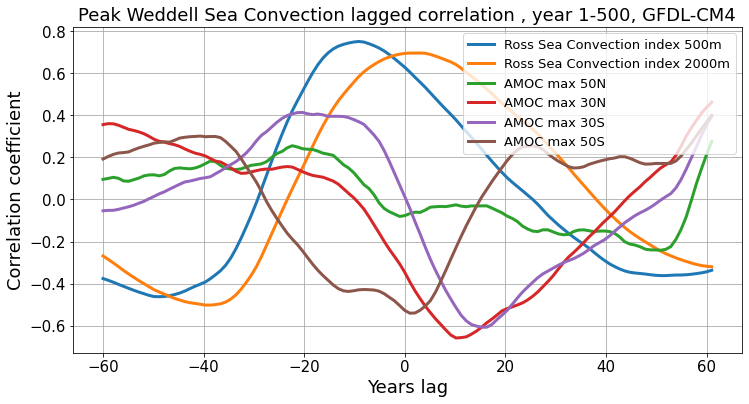

In [152]:
lag_time = 60

fig = plt.figure(figsize = (12,6))
lag_cor(conv_ind_ws, conv_ind_rs, lag_time, 'C0', 'Ross Sea Convection index 500m')
lag_cor(conv_ind_ws, conv_ind_rs2, lag_time, 'C1', 'Ross Sea Convection index 2000m')
lag_cor(conv_ind_ws, AMOC_dict['50'], lag_time, 'C2', 'AMOC max 50N')
lag_cor(conv_ind_ws, AMOC_dict['30'], lag_time, 'C3', 'AMOC max 30N')
lag_cor(conv_ind_ws, AMOC_dict['-30'], lag_time, 'C4','AMOC max 30S')
lag_cor(conv_ind_ws, AMOC_dict['-50'], lag_time, 'C5','AMOC max 50S')


# lag_cor(conv_ind_rs2, Sv_U_SO_WS_min_norm[:-9],lag_time,'c','Weddell Sea Barotrophic Streamfunction min')


''' !!!Problem need to be solved here !!!!'''
##### Q: Why -9 here? ######

plt.xlabel('Years lag', fontsize=18)
plt.ylabel('Correlation coefficient', fontsize=18)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(fontsize = 13)
plt.title('Peak Weddell Sea Convection lagged correlation , year {}-{}, {}'.format(
    start_year, end_year, model_name), fontsize=18)

Text(0.5, 1.0, 'Peak Weddell Sea Convection lagged correlation , year 1-500, GFDL-CM4')

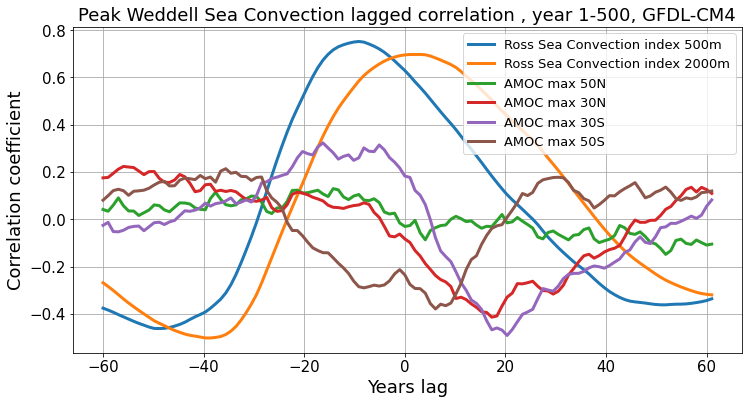

In [153]:
lag_time = 60

fig = plt.figure(figsize = (12,6))
lag_cor(conv_ind_ws, conv_ind_rs, lag_time, 'C0', 'Ross Sea Convection index 500m')
lag_cor(conv_ind_ws, conv_ind_rs2, lag_time, 'C1', 'Ross Sea Convection index 2000m')
lag_cor(conv_ind_ws, AMOC_max.sel(y=50, method = 'nearest'), lag_time, 'C2', 'AMOC max 50N')
lag_cor(conv_ind_ws, AMOC_max.sel(y=30, method = 'nearest'), lag_time, 'C3', 'AMOC max 30N')
lag_cor(conv_ind_ws, AMOC_max.sel(y=-30, method = 'nearest'), lag_time, 'C4','AMOC max 30S')
lag_cor(conv_ind_ws, AMOC_max.sel(y=-50, method = 'nearest'), lag_time, 'C5','AMOC max 50S')


# lag_cor(conv_ind_rs2, Sv_U_SO_WS_min_norm[:-9],lag_time,'c','Weddell Sea Barotrophic Streamfunction min')


''' !!!Problem need to be solved here !!!!'''
##### Q: Why -9 here? ######

plt.xlabel('Years lag', fontsize=18)
plt.ylabel('Correlation coefficient', fontsize=18)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(fontsize = 13)
plt.title('Peak Weddell Sea Convection lagged correlation , year {}-{}, {}'.format(
    start_year, end_year, model_name), fontsize=18)

Text(0.5, 1.0, 'Peak Weddell Sea Convection lagged correlation , year 1-500, GFDL-CM4')

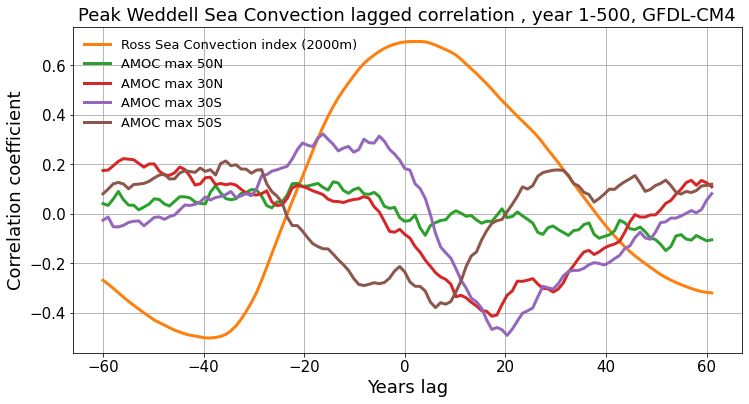

In [39]:
lag_time = 60

fig = plt.figure(figsize = (12,6))
lag_cor(conv_ind_ws, conv_ind_rs2, lag_time, 'C1', 'Ross Sea Convection index (2000m)')
lag_cor(conv_ind_ws, AMOC_max.sel(y=50, method = 'nearest'), lag_time, 'C2', 'AMOC max 50N')
lag_cor(conv_ind_ws, AMOC_max.sel(y=30, method = 'nearest'), lag_time, 'C3', 'AMOC max 30N')
lag_cor(conv_ind_ws, AMOC_max.sel(y=-30, method = 'nearest'), lag_time, 'C4','AMOC max 30S')
lag_cor(conv_ind_ws, AMOC_max.sel(y=-50, method = 'nearest'), lag_time, 'C5','AMOC max 50S')


# lag_cor(conv_ind_rs2, Sv_U_SO_WS_min_norm[:-9],lag_time,'c','Weddell Sea Barotrophic Streamfunction min')


''' !!!Problem need to be solved here !!!!'''
##### Q: Why -9 here? ######

plt.xlabel('Years lag', fontsize=18)
plt.ylabel('Correlation coefficient', fontsize=18)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(fontsize = 13,frameon=False)
plt.title('Peak Weddell Sea Convection lagged correlation , year {}-{}, {}'.format(
    start_year, end_year, model_name), fontsize=18)

Text(0.5, 1.0, 'Peak Weddell Sea Convection lagged correlation , year 1-500, GFDL-CM4')

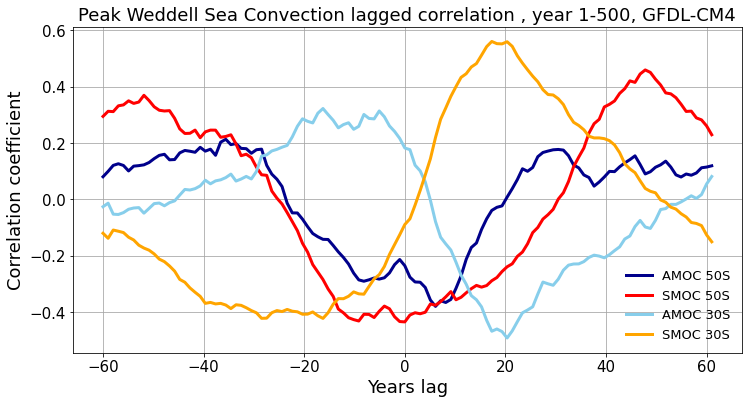

In [49]:
lag_time = 60

fig = plt.figure(figsize = (12,6))
# lag_cor(conv_ind_ws, conv_ind_rs2, lag_time, 'C1', 'Ross Sea Convection index (2000m)')
lag_cor(conv_ind_ws, AMOC_max.sel(y=-50, method = 'nearest'), lag_time, 'darkblue', 'AMOC 50S')
lag_cor(conv_ind_ws, np.abs(SMOC_min.sel(y=-50, method = 'nearest')), lag_time, 'red', 'SMOC 50S')
lag_cor(conv_ind_ws, AMOC_max.sel(y=-30, method = 'nearest'), lag_time, 'skyblue','AMOC 30S')
lag_cor(conv_ind_ws, np.abs(SMOC_min.sel(y=-30, method = 'nearest')), lag_time, 'orange','SMOC 30S')


# lag_cor(conv_ind_rs2, Sv_U_SO_WS_min_norm[:-9],lag_time,'c','Weddell Sea Barotrophic Streamfunction min')


''' !!!Problem need to be solved here !!!!'''
##### Q: Why -9 here? ######

plt.xlabel('Years lag', fontsize=18)
plt.ylabel('Correlation coefficient', fontsize=18)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(fontsize = 13,frameon=False)
plt.title('Peak Weddell Sea Convection lagged correlation , year {}-{}, {}'.format(
    start_year, end_year, model_name), fontsize=18)

Text(0.5, 1.0, 'Peak Weddell Sea Convection lagged correlation , year 1-500, GFDL-CM4')

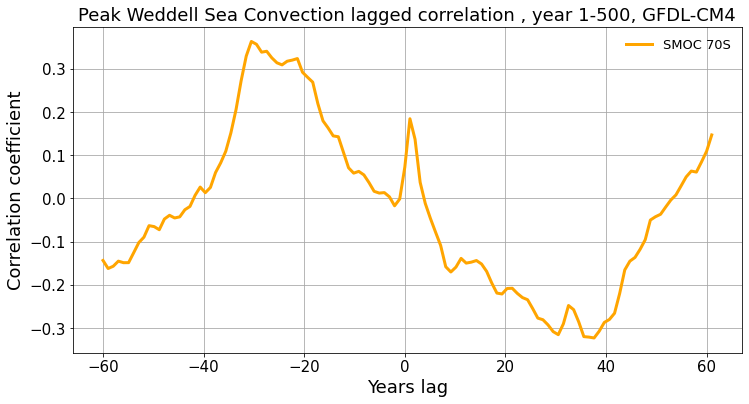

In [55]:
lag_time = 60

fig = plt.figure(figsize = (12,6))
# lag_cor(conv_ind_ws, conv_ind_rs2, lag_time, 'C1', 'Ross Sea Convection index (2000m)')
# lag_cor(conv_ind_ws, AMOC_max.sel(y=-50, method = 'nearest'), lag_time, 'darkblue', 'AMOC 50S')
# lag_cor(conv_ind_ws, -1*SMOC_min.sel(y=-50, method = 'nearest'), lag_time, 'red', 'SMOC 50S')
# lag_cor(conv_ind_ws, AMOC_max.sel(y=-30, method = 'nearest'), lag_time, 'skyblue','AMOC 30S')
lag_cor(conv_ind_ws, -1*SMOC_min.sel(y=-70, method = 'nearest'), lag_time, 'orange','SMOC 70S')


# lag_cor(conv_ind_rs2, Sv_U_SO_WS_min_norm[:-9],lag_time,'c','Weddell Sea Barotrophic Streamfunction min')


''' !!!Problem need to be solved here !!!!'''
##### Q: Why -9 here? ######

plt.xlabel('Years lag', fontsize=18)
plt.ylabel('Correlation coefficient', fontsize=18)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(fontsize = 13,frameon=False)
plt.title('Peak Weddell Sea Convection lagged correlation , year {}-{}, {}'.format(
    start_year, end_year, model_name), fontsize=18)

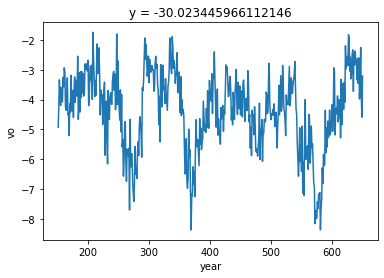

In [65]:
SMOC_min.sel(y=-30, method = 'nearest').plot()

Text(0.5, 1.0, 'Peak Ross Sea Convection lagged correlation , year 1-500, GFDL-CM4')

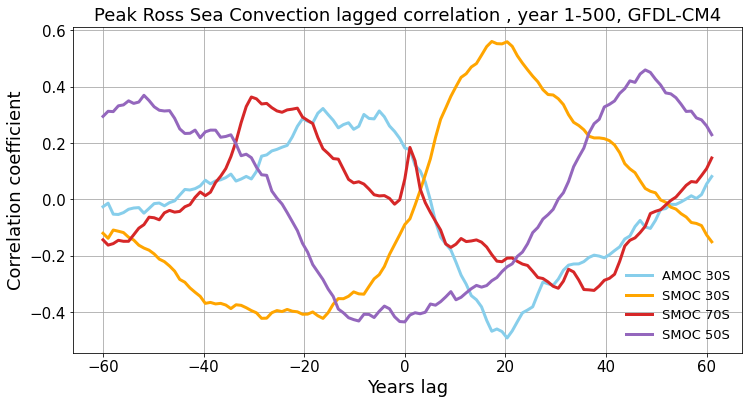

In [58]:
lag_time = 60

fig = plt.figure(figsize = (12,6))
# lag_cor(conv_ind_ws, conv_ind_rs2, lag_time, 'C1', 'Ross Sea Convection index (2000m)')
# lag_cor(conv_ind_ws, AMOC_max.sel(y=-50, method = 'nearest'), lag_time, 'darkblue', 'AMOC 50S')
# lag_cor(conv_ind_ws, -1*SMOC_min.sel(y=-50, method = 'nearest'), lag_time, 'red', 'SMOC 50S')
lag_cor(conv_ind_ws, AMOC_max.sel(y=-30, method = 'nearest'), lag_time, 'skyblue','AMOC 30S')
lag_cor(conv_ind_ws, -1*SMOC_min.sel(y=-30, method = 'nearest'), lag_time, 'orange','SMOC 30S')
lag_cor(conv_ind_ws, -1*SMOC_min.sel(y=-70, method = 'nearest'), lag_time, 'C3','SMOC 70S')
lag_cor(conv_ind_ws, -1*SMOC_min.sel(y=-50, method = 'nearest'), lag_time, 'C4','SMOC 50S')

# lag_cor(conv_ind_rs2, Sv_U_SO_WS_min_norm[:-9],lag_time,'c','Weddell Sea Barotrophic Streamfunction min')


''' !!!Problem need to be solved here !!!!'''
##### Q: Why -9 here? ######

plt.xlabel('Years lag', fontsize=18)
plt.ylabel('Correlation coefficient', fontsize=18)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(fontsize = 13,frameon=False)
plt.title('Peak Weddell Sea Convection lagged correlation , year {}-{}, {}'.format(
    start_year, end_year, model_name), fontsize=18)

Text(0.5, 1.0, 'Lagged correlation (Ross Sea Convection index), year 1-500, GFDL-CM4')

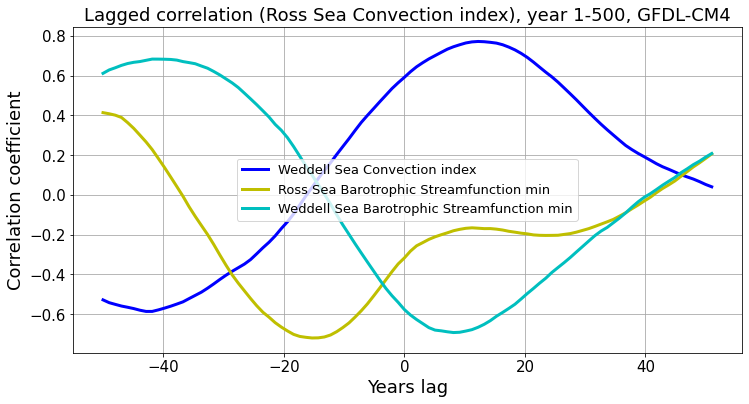

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError


In [50]:
lag_time = 50

fig = plt.figure(figsize = (12,6))
lag_cor(conv_ind_rs[:-9], conv_ind_ws[:-9],lag_time,'b','Weddell Sea Convection index')
lag_cor(conv_ind_rs[:-9], Sv_U_SO_RS_min_norm[:-9],lag_time,'y','Ross Sea Barotrophic Streamfunction min')
lag_cor(conv_ind_rs[:-9], Sv_U_SO_WS_min_norm[:-9],lag_time,'c','Weddell Sea Barotrophic Streamfunction min')


''' !!!Problem need to be solved here !!!!'''
##### Q: Why -9 here? ######

plt.xlabel('Years lag', fontsize=18)
plt.ylabel('Correlation coefficient', fontsize=18)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(fontsize = 13)
plt.title('Lagged correlation (Ross Sea Convection index), year {}-{}, GFDL-CM4'.format(start_year, end_year), fontsize=18)

In [34]:
client.close()
cluster.close()